Add early stop // explain it as well
Move visualizations up

In [1]:
# PyTorch Libraries for Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split    # Scikit-Lean for preparing the train-test data split

# Pandas for reading data in .csv format 
import pandas as pd

# Plotting tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objs as go

In [38]:
def data_visualization(data, duration, randomseed=False):
    dim1, dim2, dim3 = np.array(data['hand_orig_rua_x']), np.array(data['hand_orig_rua_y']), np.array(data['hand_orig_rua_z'])

    if duration is not None:
        # reduced_samples = int(reduceby * len(dim1))
        # random_indices = np.random.choice(len(dim1), size=reduced_samples, replace=False)
        # dim1, dim2, dim3 = dim1[random_indices], dim2[random_indices], dim3[random_indices]

        # rand_index = np.random.randint(int(0.05 * len(data)), int(0.4 * len(data)))
        # dim1, dim2, dim3 = dim1[rand_index: rand_index + duration * 100], dim2[rand_index + duration * 100], dim3[rand_index + duration * 100]
        if randomseed == True:
            np.random.seed(42)
        else: 
            np.random.seed(None)
        reduced_samples = 100 * duration
        start_index = np.random.choice(len(dim1) - reduced_samples + 1)
        dim1 = dim1[start_index : start_index + reduced_samples]
        dim2 = dim2[start_index : start_index + reduced_samples]
        dim3 = dim3[start_index : start_index + reduced_samples]
        # print(start_index, start_index + reduced_samples)
        # print(dim1)

    return dim1, dim2, dim3

def pltshow(x_lable, y_label, title, legend = False):
    
    plt.xlabel(x_lable)
    plt.ylabel(y_label)
    plt.title(title)
    if legend == True:
        plt.legend()
    plt.show()
    
def output_visualization(data, duration=None, randomseed=False):
    dim1, dim2, dim3 = data_visualization(data, duration, randomseed)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(dim1, dim2, dim3, c='b', marker='o')

    ax.set_xlabel('X-Dimension')
    ax.set_ylabel('Y-Dimension')
    ax.set_zlabel('Z-Dimension')
    ax.set_title('Predicted Values in 3D Space')

    plt.show()

def interactive_output_visualization(data, duration=None, randomseed=False):
    dim1, dim2, dim3 = data_visualization(data, duration, randomseed)
    
    trace = go.Scatter3d(x=dim1, y=dim2, z=dim3, mode='markers', marker=dict(size=5, 
                                                                             color='blue', 
                                                                             opacity=0.8))

    layout = go.Layout(title='Predicted Values in 3D Space', scene=dict(xaxis=dict(title='X-Dimension'),
                                                                        yaxis=dict(title='Y-Dimension'),
                                                                        zaxis=dict(title='Z-Dimension')))

    fig = go.Figure(data=[trace], layout=layout)
    fig.show()

def correlationPlot(data):
    pressure_label = "sw_pres"  # Smart Watch Pressure
    yPos_label = "hand_orig_rua_y"    # Y Hand Position
    dim1, dim2 = np.array(data[pressure_label]), np.array(data[yPos_label])
    dim1, dim2 = dim1[1:], dim2[1:]
    
    slope, intercept = np.polyfit(dim1, dim2, deg=1)
    regression_line = slope * dim1 + intercept

    mse = np.mean((dim2 - regression_line)**2)

    plt.scatter(dim1, dim2, c='b', marker='.')
    plt.plot(dim1, regression_line, c='r', label='Linear Fit')
    pltshow("Smart Watch Pressure", "Y Hand Positon", f"Correlation between {pressure_label} & {yPos_label}\nMSE: {mse: .3f}", legend=True)

def accDistPlot(data):
    column_name = "sw_lacc_y"  
    acceleration_values = data[column_name]
    
    plt.plot(list(range(1, 1 + len(acceleration_values))), acceleration_values, color= 'b')
    pltshow("Time", "Acceleration", "Distribution of Acceleration over Time")

    mean_acceleration = np.mean(acceleration_values)
    std_acceleration = np.std(acceleration_values)
    plt.hist(acceleration_values, bins='auto', density=True, alpha=0.7, color='b')
    x = np.linspace(mean_acceleration - 3 * std_acceleration, mean_acceleration + 3 * std_acceleration, 100)
    y = (1 / (std_acceleration * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_acceleration) / std_acceleration) ** 2)
    plt.plot(x, y, color='r')
    pltshow('Acceleration', 'Density','Distribution of Acceleration Over Time')

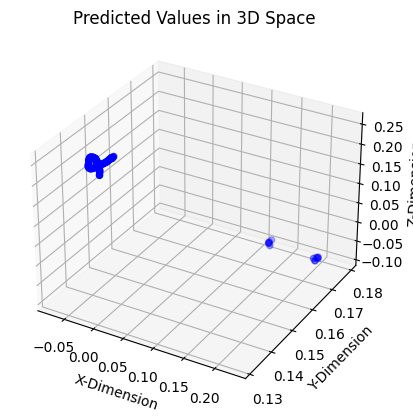

In [41]:
file_path = '/Users/affanbinusman/Dropbox (ASU)/IRL-Lab/P&G/hackathon_data/watch_phone_motive_rec_2023-07-07_17-28-44.csv'     # Update path where your data is located
data = pd.read_csv(file_path)

duration = 1       
# output_visualization(data)
output_visualization(data, duration=duration, randomseed=False)

# interactive_output_visualization(data)
interactive_output_visualization(data, duration=duration, randomseed=False)

# correlationPlot(data)

# accDistPlot(data)

Importing libraries 

Model Architecture & Data Loader

In [4]:
"""
    Data Loader: 
        This serves as the framework to load data using pandas and segment out the useful columns (labels and inputs)
"""

class MyDataset(Dataset):
    def __init__ (self, file_path):
        self.data = pd.read_csv(file_path)
        self.features = self.data.iloc[:, 19:36].values     # All smart watch inputs that contribute towards the outputs
        self.labels = self.data.iloc[:, :3].values          # The model predicts X, Y, Z coordinates of hand

    def __len__ (self):
        return len(self.data)
    
    def __getitem__ (self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32) 
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return features, label
    
"""
    Neural Network / Model:
        A simple linear architecture based model with 3 layers (including input and output layers). 
        The layer dimensions are: 17 - 128 - 3
"""

class MyModel(nn.Module):
    def __init__ (self, input_size, hidden_size, output_size):
        super (MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [9]:
"""
    We encourage you to play around with these parameters to see what works better for this model architecture and dataset.
"""
batch_size = 500        
learning_rate = 0.001
num_epochs = 100
test_data_size = 0.2            # Range 0-1. You may increase or decrease the recommended testing data size by updating this variable

hidden_size = 128               # This represents the middle layer of the neural network. You may manually play around with the model architecture by adding more layers
criterion = nn.SmoothL1Loss()   # Try out different loss functions and optimizers to see what works with different tasks. 

patience = 5
best_loss = float('inf')
num_epochs_without_improvement = 0

In [10]:
# Data loading calls to class and functions
dataset = MyDataset(file_path)

train_dataset, test_dataset = train_test_split(dataset, test_size=test_data_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialzing the model with inputs
input_size = len(dataset.features[0])
output_size = len(dataset.labels[0])

model = MyModel(input_size, hidden_size, output_size)
criterion = nn.SmoothL1Loss() #mean square / regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)        # For more information, visit: https://pytorch.org/docs/stable/nn.html#loss-functions, https://pytorch.org/docs/stable/optim.html

"""
    If you have GPU resource available, the training process will be faster!
    It's okay if you dont have a GPU. The code works without one as well. 
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MyModel(
  (fc1): Linear(in_features=17, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [11]:
# Training & Evaluation Porcess
losses_train = []       # For visually observing the losses
losses_eval = []

for epoch in range(num_epochs):
    
    # Training Process
    model.train(True)
    running_loss = 0.0                          # To calculates the losses in training for each epoch
    for inputs, labels in train_loader:
        inputs = inputs.to(device)              # Transfers data to GPU/CPU
        labels = labels.to(device)
        
        optimizer.zero_grad()                   # Zeros the optimizer before generating output
        outputs = model(inputs)                 # Calculates the output
        loss = criterion(outputs, labels)       # Finds loss as per the criteria defined
        loss.backward()                         # Back propogation of loss
        optimizer.step()                        # Updates parameters based on gradients computed duing back propogation
        
        running_loss += loss.item()             # Calculates loss over the training
    
    """
    Evaluating the model that has been trained (so far). 
    You would notice similar steps as during the training process. The lack of a few lines of code is because we 
    are evaluating the model here and not training it.
    """
    model.train(False)
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    mean_loss = total_loss / len(test_loader)

    if mean_loss < best_loss:
        best_loss = mean_loss
        num_epochs_without_improvement = 0
    else:
        num_epochs_without_improvement += 1
        if num_epochs_without_improvement == patience:
            print("Early stopping triggered. Stopping training.")
            break


    losses_train.append(running_loss)
    losses_eval.append(mean_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Smooth L1 Loss: {mean_loss}")

Epoch 1/100, Training Loss: 6.0741783434694465, Smooth L1 Loss: 1.390955626964569
Epoch 2/100, Training Loss: 0.8031149811365388, Smooth L1 Loss: 0.4012820969025294
Epoch 3/100, Training Loss: 0.14154201153327117, Smooth L1 Loss: 0.0551059457163016
Epoch 4/100, Training Loss: 0.040023016912693325, Smooth L1 Loss: 0.03138078097254038
Epoch 5/100, Training Loss: 0.028251522220671177, Smooth L1 Loss: 0.026616413767139118
Epoch 6/100, Training Loss: 0.023423429747874088, Smooth L1 Loss: 0.021899699543913204
Epoch 7/100, Training Loss: 0.020829796537079594, Smooth L1 Loss: 0.019185352760056656
Epoch 8/100, Training Loss: 0.018366604366085747, Smooth L1 Loss: 0.017861126301189263
Epoch 9/100, Training Loss: 0.017069440843029457, Smooth L1 Loss: 0.016699816876401503
Epoch 10/100, Training Loss: 0.015572632662951946, Smooth L1 Loss: 0.015599869191646576
Epoch 11/100, Training Loss: 0.014299363490532745, Smooth L1 Loss: 0.01401068146030108
Epoch 12/100, Training Loss: 0.013158506375144829, Smoo

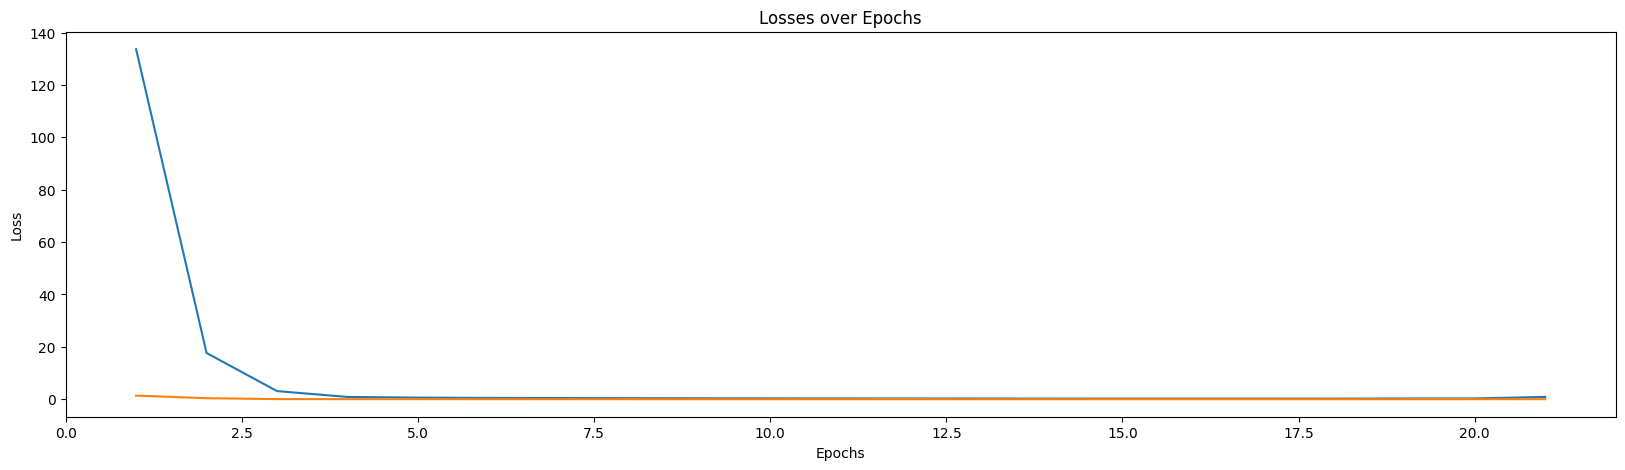

In [12]:
mean_training, std_training = np.mean(losses_train), np.std(losses_train)
mean_eval, std_eval = np.mean(losses_eval), np.std(losses_eval)
epochs_total = range(1, 1 + len(losses_train))

plt.subplots(1, figsize=(20,5))
plt.plot(epochs_total, losses_train, label = "Training Loss")
plt.plot(epochs_total, losses_eval, label = "Evaluation Loss")
pltshow('Epochs', 'Loss', 'Losses over Epochs')

Visualizations

correlation plots / pressure & y-pos hand
3d visualization of ground truth
distrubution of accelaration